# Monte Carlo Simulation and Exotic Option Pricing

This notebook explores Monte Carlo capabilities in **dervflow**. We simulate price paths, estimate European option values with convergence diagnostics, and price exotic contracts such as Asian and barrier options.

## 1. Imports

We import the Monte Carlo engine, option pricer, and exotic option helpers from `dervflow`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dervflow import (
    MonteCarloEngine,
    MonteCarloOptionPricer,
    BlackScholesModel,
    AsianOption,
    BarrierOption
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Simulate Geometric Brownian Motion Paths

We generate Monte Carlo paths for an equity following a geometric Brownian motion (GBM).

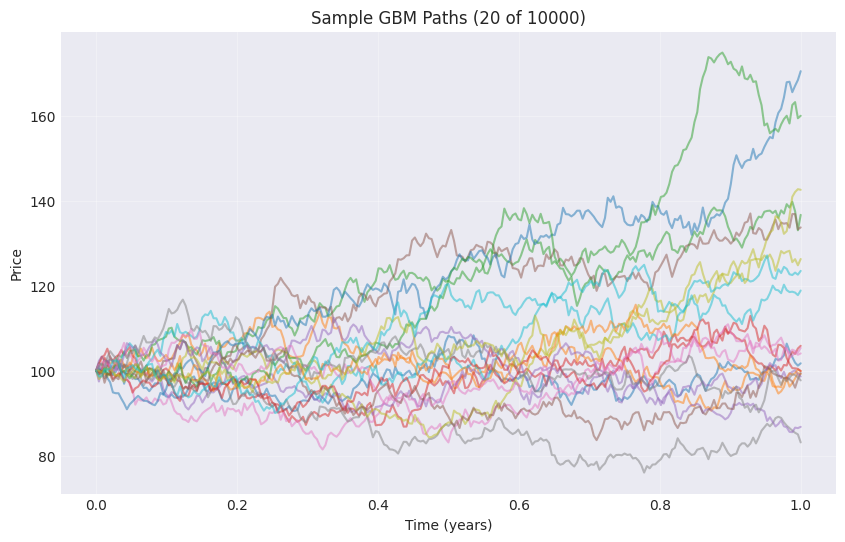

,Terminal Price Distribution
mean,108.333989
std,22.067988
min,42.206504
max,245.554504
p05,75.595725
p95,147.463492


In [2]:
engine = MonteCarloEngine(seed=42)

spot = 100.0
mu = 0.08  # annualized drift
volatility = 0.2
time_horizon = 1.0  # years
steps = 252  # daily steps
num_paths = 10000

gbm_paths = engine.simulate_gbm(
    s0=spot,
    mu=mu,
    sigma=volatility,
    T=time_horizon,
    steps=steps,
    paths=num_paths,
    parallel=False
)
gbm_paths = np.array(gbm_paths)
time_grid = np.linspace(0.0, time_horizon, steps + 1)

plt.figure(figsize=(10, 6))
for path in gbm_paths[:20]:
    plt.plot(time_grid, path, alpha=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Price')
plt.title('Sample GBM Paths (20 of {})'.format(num_paths))
plt.grid(True, alpha=0.3)
plt.show()

terminal_prices = gbm_paths[:, -1]
summary = pd.Series(terminal_prices).describe()[['mean', 'std', 'min', 'max']]
summary['p05'] = np.percentile(terminal_prices, 5)
summary['p95'] = np.percentile(terminal_prices, 95)
summary.to_frame(name='Terminal Price Distribution')

## 3. European Option Pricing Convergence

We estimate a European call price using Monte Carlo with increasing path counts and compare the results against the Black-Scholes benchmark.

In [3]:
pricer = MonteCarloOptionPricer()
bs = BlackScholesModel()

strike = 100.0
rate = 0.05
dividend = 0.0
maturity = 1.0

bs_price = bs.price(spot, strike, rate, dividend, volatility, maturity, 'call')
path_grid = [5000, 10000, 25000, 50000]
records = []
for paths in path_grid:
    result = pricer.price_european(
        spot,
        strike,
        rate,
        dividend,
        volatility,
        maturity,
        'call',
        num_paths=paths,
        use_antithetic=True,
        seed=42,
        parallel=False
    )
    records.append({
        'Paths': paths,
        'Price': result['price'],
        'Std Error': result['std_error'],
        'Abs Error vs BS': abs(result['price'] - bs_price)
    })
convergence_df = pd.DataFrame(records)
convergence_df

,Paths,Price,Std Error,Abs Error vs BS
0,5000,10.442173,0.208058,0.008402
1,10000,10.425995,0.147999,0.024580
2,25000,10.447321,0.093512,0.003255
3,50000,10.446460,0.065991,0.004115


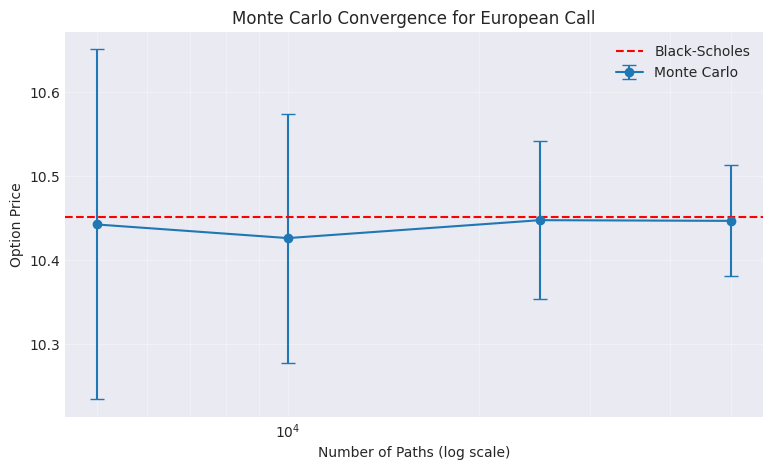

In [4]:
plt.figure(figsize=(9, 5))
plt.errorbar(
    convergence_df['Paths'],
    convergence_df['Price'],
    yerr=convergence_df['Std Error'],
    fmt='o-',
    capsize=5,
    label='Monte Carlo'
)
plt.axhline(bs_price, color='r', linestyle='--', label='Black-Scholes')
plt.xscale('log')
plt.xlabel('Number of Paths (log scale)')
plt.ylabel('Option Price')
plt.title('Monte Carlo Convergence for European Call')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

## 4. American Option via Longstaff-Schwartz

Using the same parameters we compute the early-exercise premium of an American put.

In [5]:
american_result = pricer.price_american(
    spot,
    strike,
    rate,
    dividend,
    volatility,
    maturity,
    'put',
    num_paths=40000,
    num_steps=75,
    seed=42,
    parallel=False
)
euro_put = pricer.price_european(
    spot,
    strike,
    rate,
    dividend,
    volatility,
    maturity,
    'put',
    num_paths=50000,
    use_antithetic=True,
    seed=42,
    parallel=False
)
pd.DataFrame({
    'Metric': ['American Put', 'European Put', 'Early-Exercise Premium'],
    'Value': [
        american_result['price'],
        euro_put['price'],
        american_result['price'] - euro_put['price']
    ]
})

,Metric,Value
0,American Put,6.067573
1,European Put,5.565219
2,Early-Exercise Premium,0.502354


## 5. Asian Option Pricing

We price an arithmetic-average Asian call using Monte Carlo with variance reduction.

In [6]:
asian = AsianOption()
asian_stats = asian.price_arithmetic_stats(
    spot=spot,
    strike=100.0,
    rate=rate,
    dividend=dividend,
    volatility=volatility,
    time=maturity,
    option_type='call',
    num_observations=12,
    fixed_strike=True,
    num_paths=60000,
    seed=42,
    use_antithetic=True,
    use_control_variate=True
)
asian_stats

{'price': 5.722178332555084, 'std_error': 0.0009467483736514261}

## 6. Barrier Option Pricing

Finally, we value a down-and-out call using the semi-analytical barrier option engine.

In [7]:
barrier = BarrierOption()
barrier_price = barrier.price(
    spot=spot,
    strike=strike,
    rate=rate,
    dividend=dividend,
    volatility=volatility,
    time=maturity,
    option_type='call',
    barrier=90.0,
    barrier_type='down-and-out',
    rebate=0.0
)
print(f'Down-and-out call price: {barrier_price:.4f}')

Down-and-out call price: 1.6335
